# **Image Colorization**

# **Import Libraries**

In [15]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imshow
import matplotlib.pyplot as plt
import warnings
from skimage.metrics import structural_similarity as ssim
warnings.filterwarnings("ignore")

In [11]:
# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

## **Exploratiry Data Analysis**

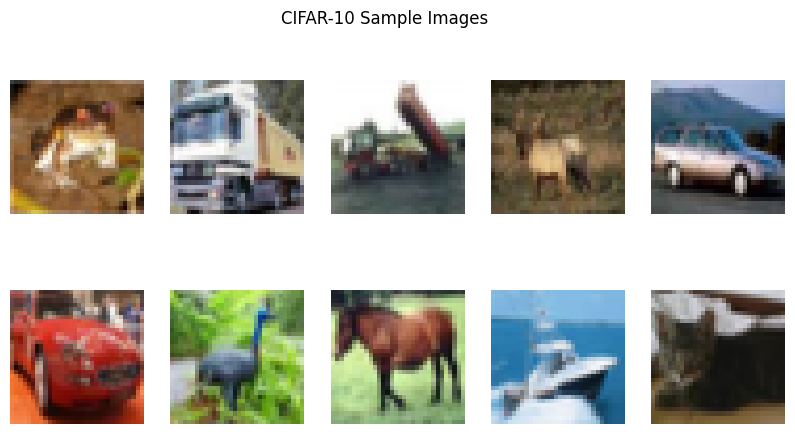

In [25]:
# Visualize some sample images
def plot_sample_images(images, title="Sample Images"):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)

        # Convert images to RGB format if needed
        img = images[i]
        if img.shape[-1] == 1:  # If grayscale, convert to RGB
            img = np.stack([img.squeeze()] * 3, axis=-1)
        elif np.max(img) <= 1.0:  # If normalized, scale to [0, 255]
            img = (img * 255).astype(np.uint8)

        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

plot_sample_images(x_train, title="CIFAR-10 Sample Images")

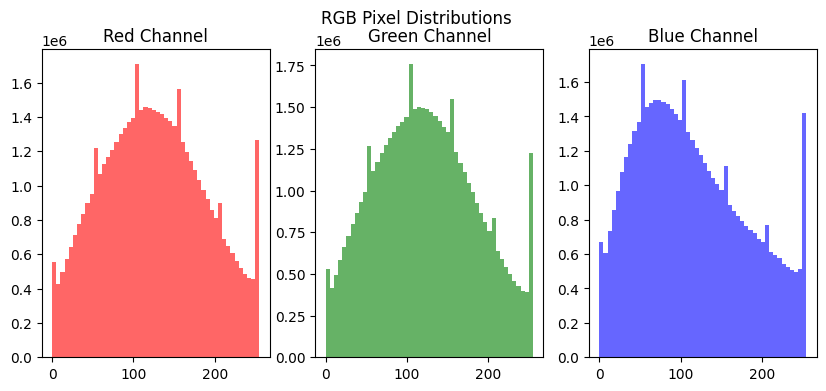

In [13]:
# Inspect pixel intensity distributions
def plot_pixel_distributions(images, title="Pixel Intensity Distribution"):
    plt.figure(figsize=(10, 4))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        plt.subplot(1, 3, i + 1)
        plt.hist(images[:, :, :, i].flatten(), bins=50, color=color.lower(), alpha=0.6)
        plt.title(f"{color} Channel")
    plt.suptitle(title)
    plt.show()

plot_pixel_distributions(x_train, title="RGB Pixel Distributions")

## **Data Preprocessing**

In [5]:
# Convert RGB to LAB and normalize
def rgb_to_lab_dataset(data):
    lab_data = np.zeros(data.shape)
    for i, img in enumerate(data):
        lab_data[i] = rgb2lab(img)
    return lab_data

# Convert and split into input/output
train_lab = rgb_to_lab_dataset(x_train / 255.0)
test_lab = rgb_to_lab_dataset(x_test / 255.0)

x_train_l = train_lab[:, :, :, 0:1] / 100  # Normalize L to 0-1
y_train_ab = train_lab[:, :, :, 1:] / 128  # Normalize a, b to -1 to 1

x_test_l = test_lab[:, :, :, 0:1] / 100
y_test_ab = test_lab[:, :, :, 1:] / 128

## **Model Building**
- **Simple CNN**

In [6]:
cnn_model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(2, (3, 3), activation='tanh', padding='same')
])
cnn_model.compile(optimizer='adam', loss='mse')


- **U-Net**

In [7]:
def unet_model(input_shape=(32, 32, 1)):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    bottleneck = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    u3 = layers.UpSampling2D((2, 2))(bottleneck)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u4 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)

    outputs = layers.Conv2D(2, (3, 3), activation='tanh', padding='same')(c4)
    model = models.Model(inputs, outputs)
    return model

unet = unet_model()
unet.compile(optimizer='adam', loss='mse')


## **Training**
- **CNN Training**

In [8]:
# Train both models
cnn_model.fit(x_train_l, y_train_ab, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0107 - val_loss: 0.0096
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 9/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 10/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0091 - val_loss: 0.0093


- **U-Net Training**

In [9]:
unet.fit(x_train_l, y_train_ab, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 9/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 10/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0090 - val_loss: 0.0091


## **Model Evaluation**

In [22]:
def evaluate_model(model, x_l, y_ab, num_images=5):
    predictions = model.predict(x_l[:num_images])
    mse_scores = []
    ssim_scores = []

    for i in range(num_images):
        # Reconstruct image
        l_channel = x_l[i].reshape(32, 32) * 100
        ab_channels = predictions[i] * 128
        original_ab = y_ab[i] * 128

        # Calculate MSE
        mse = np.mean((ab_channels - original_ab) ** 2)
        mse_scores.append(mse)

        # Convert to RGB for SSIM calculation
        colorized_img = lab2rgb(np.stack([l_channel, ab_channels[:, :, 0], ab_channels[:, :, 1]], axis=-1))
        original_img = lab2rgb(np.stack([l_channel, original_ab[:, :, 0], original_ab[:, :, 1]], axis=-1))

        # Calculate SSIM with data_range
        ssim_score = ssim(original_img, colorized_img, win_size=3, channel_axis=-1, data_range=1.0)
        ssim_scores.append(ssim_score)

        # Visualize results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(l_channel, cmap='gray')
        plt.title("Input (L)")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(original_img)
        plt.title("Original (a, b)")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(colorized_img)
        plt.title("Predicted (a, b)")
        plt.axis("off")
        plt.show()

    # Print metrics
    print(f"Average MSE: {np.mean(mse_scores):.4f}")

Simple CNN:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


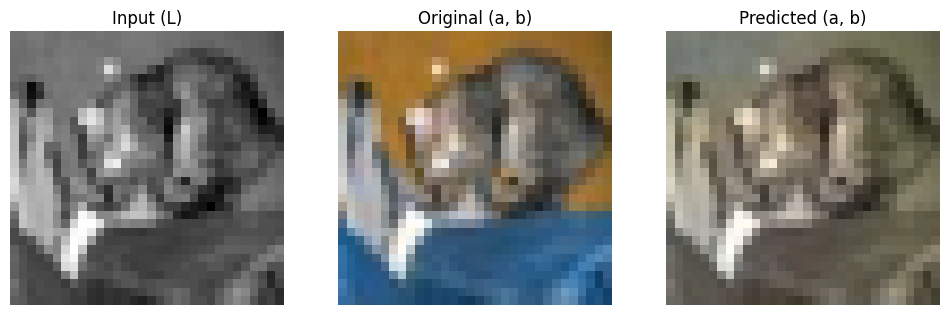

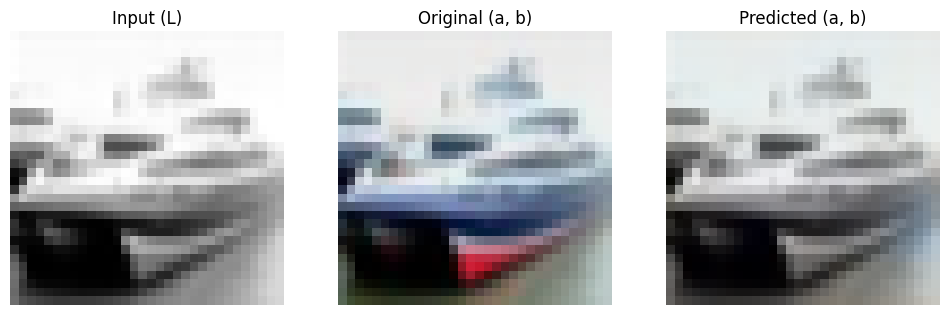

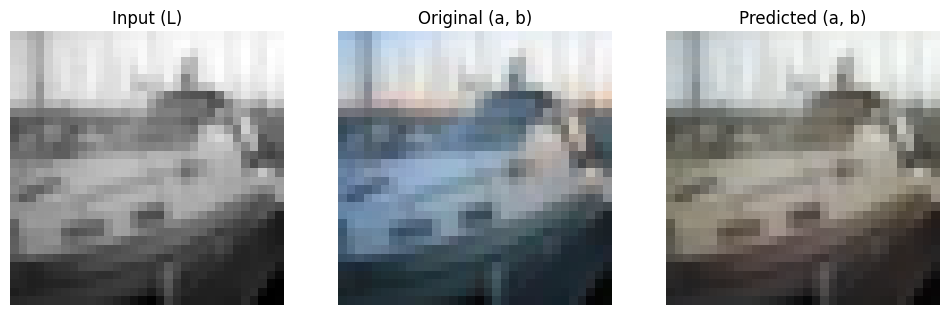

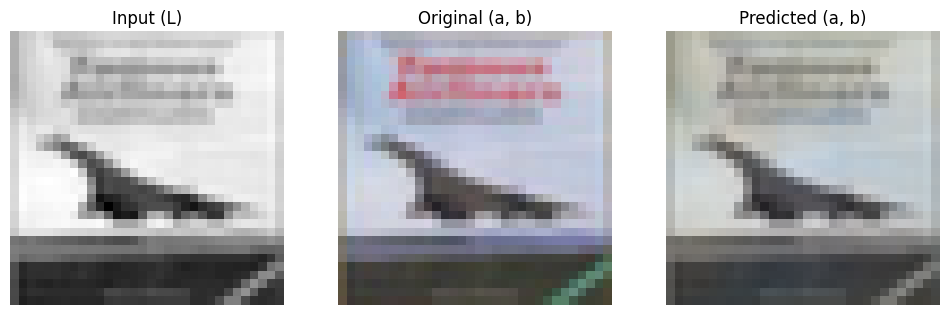

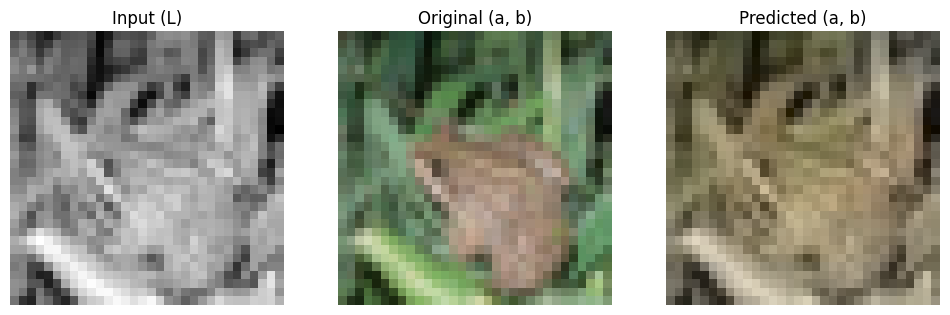

Average MSE: 138.5815


In [23]:
# Evaluate the model
print("Simple CNN:")
evaluate_model(cnn_model, x_test_l, y_test_ab)

U-Net:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


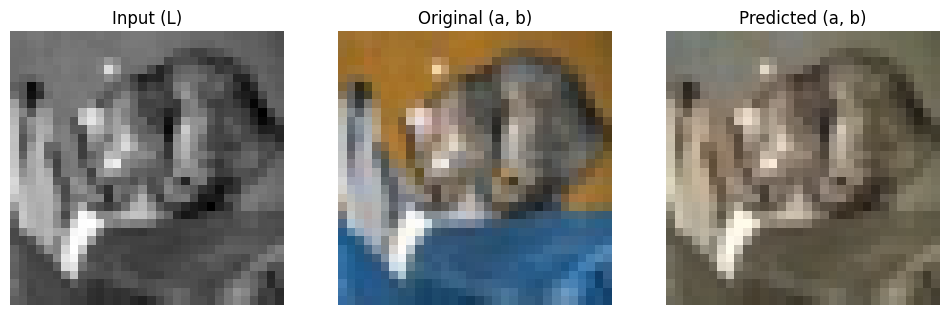

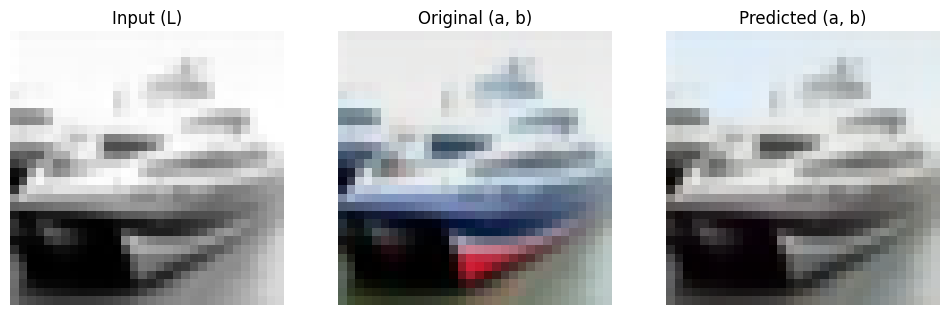

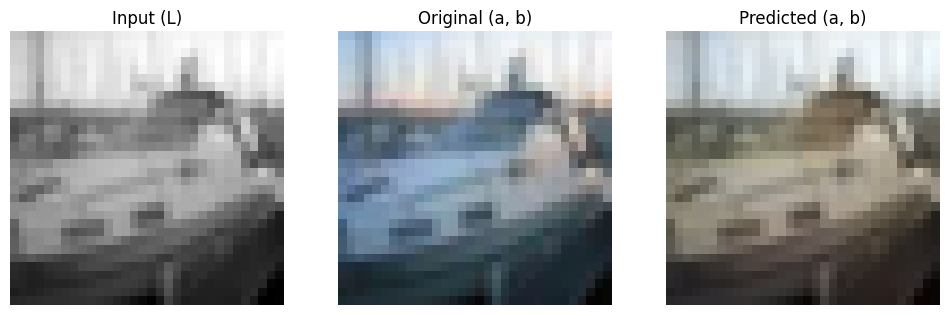

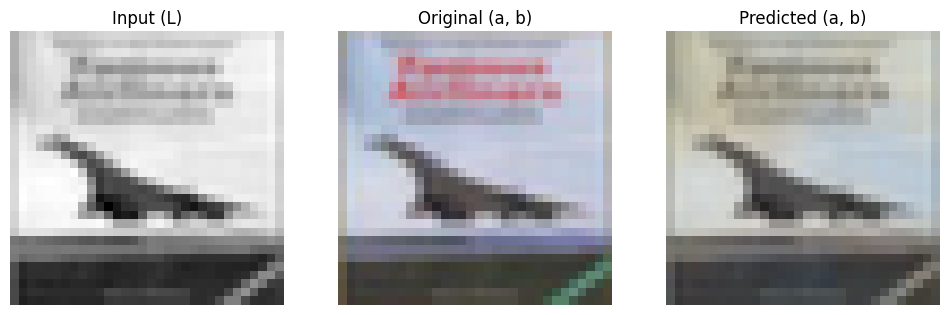

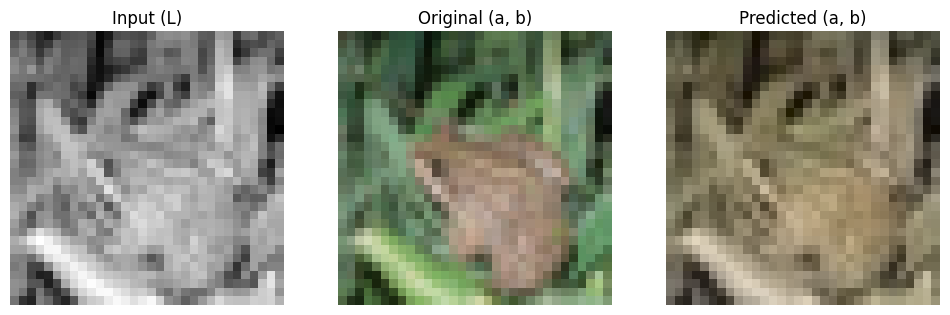

Average MSE: 156.4412


In [24]:
print("U-Net:")
evaluate_model(unet, x_test_l, y_test_ab)